In [62]:
from __future__ import print_function
import matplotlib as mpl
from matplotlib import pyplot as plt
import mxnet as mx
from mxnet import gluon, autograd, nd
from mxnet.gluon import nn
import numpy as np

ctx = mx.cpu()

In [63]:
X = nd.random_normal(shape=(1000, 2))
A = nd.array([[1, 2], [-0.1, 0.5]])
b = nd.array([1, 2])
X = nd.dot(X, A) + b
Y = nd.ones(shape=(1000,1))

# and stick them into an iterator
batch_size = 4
train_data = mx.io.NDArrayIter(X, Y, batch_size, shuffle=True)

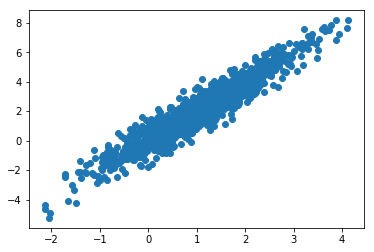

The covariance matrix is

[[ 5.          0.89999998]
 [ 0.89999998  0.25999999]]
<NDArray 2x2 @cpu(0)>


In [64]:
plt.scatter(X[:, 0].asnumpy(),X[:,1].asnumpy())
plt.show()
print("The covariance matrix is")
print(nd.dot(A, A.T))

In [128]:
# build the generator
netG = nn.Sequential()
with netG.name_scope():
    netG.add(nn.Dense(2))

# build the discriminator (with 5 and 3 hidden units respectively)
netD = nn.Sequential()
with netD.name_scope():
    netD.add(nn.Dense(5, activation='tanh'))
    netD.add(nn.Dense(3 ,activation='tanh'))
    netD.add(nn.Dense(2))

# loss
loss = gluon.loss.SoftmaxCrossEntropyLoss()

# initialize the generator and the discriminator
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': 0.01})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': 0.05})

In [130]:
real_label = mx.nd.ones((batch_size,), ctx=ctx)
fake_label = mx.nd.zeros((batch_size,), ctx=ctx)
metric = mx.metric.Accuracy()

# set up logging
from datetime import datetime
import os
import time

In [165]:
for i, batch in enumerate(train_data):
    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    # train with real_t
    data = batch.data[0].as_in_context(ctx)
    noise = nd.random_normal(shape=(batch_size, 2), ctx=ctx)
    with autograd.record():
        real_output = netD(data)
        errD_real = loss(real_output, real_label)

        fake = netG(noise)
        fake_output = netD(fake.detach())
        errD_fake = loss(fake_output, fake_label)
        errD = errD_real + errD_fake
        errD.backward()

    trainerD.step(batch_size)
    
    metric.update([real_label,], [real_output,])
    metric.update([fake_label,], [fake_output,])

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    with autograd.record():
        print(fake)
        output = netD(fake)
        print(output)
        errG = loss(output, real_label)
        errG.backward()

    
    
    break


[[-0.01940775  0.00709945]
 [ 0.00757575 -0.02821817]
 [ 0.03192177  0.00624733]
 [-0.00315145 -0.00416284]]
<NDArray 4x2 @cpu(0)>

[[ 1.31268287 -1.286448  ]
 [ 1.31640053 -1.29030395]
 [ 1.29499197 -1.26815796]
 [ 1.31165218 -1.28537774]]
<NDArray 4x2 @cpu(0)>
